# Image segmentation with Neural Network

*NGUYEN Minh Duy - WANG Qian*

## 1.Introduction to image segmentation

In digital image processing and computer vision, image segmentation is the process of partitioning a digital image into multiple image segments, also known as image regions or image objects (sets of pixels). The goal of segmentation is to simplify and/or change the representation of an image into something that is more meaningful and easier to analyze. Image segmentation is typically used to locate objects and boundaries (lines, curves, etc.) in images. More precisely, image segmentation is the process of assigning a label to every pixel in an image such that pixels with the same label share certain characteristics.

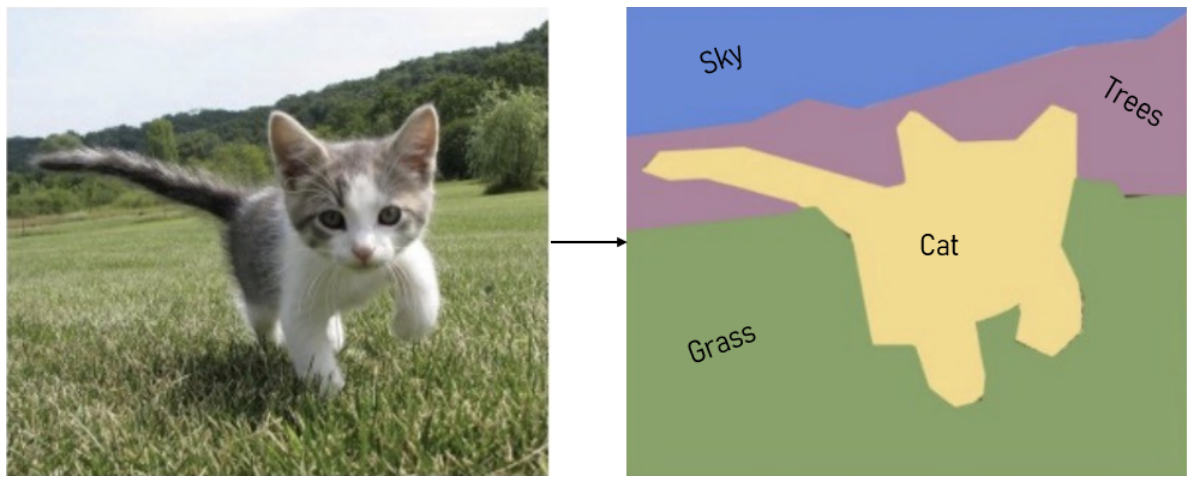


## 2.Objective
- Introduction to Pytorch (see previous tutorial notebook)
- Define a simple neural network
- Define a training procedure
- Compare difference optimization methods
- Enhance your coding skills

## 3. Construction of the neural network
We consider an image as a function from $\Omega$ to $\mathbb{R}$, where $\Omega$ is a discretization of the space $[0,1]^2$. In this notebook, we suppose that we can partition $\Omega$ into $2$ regular domains $\Omega_1$ and $\Omega_2 = \Omega /  \Omega_1$.

On each domain, we suppose that the image has different textures. We will generate these textures as stationary Gaussian processes:
- We will first generate a Gaussian noise. 
- We will then convolve this noise with a filter which describes the covariance matrix of the process. 

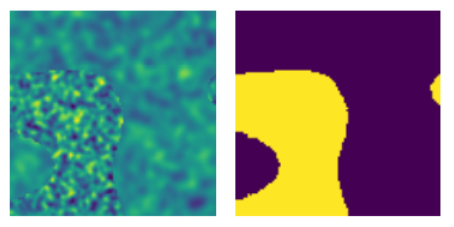

Above is an example of an image and its partition $\Omega_1$ and $\Omega_2$. The objective is from the image $u$ on the left, train a neural network to predict the mask (or the set $\omega_1$ in yellow) on the right.

- Initialization of the environment in PyTorch and necessary libraries 

In [1]:
# Importing necessary libraries 
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

# Checking if GPU is available
print(torch.cuda.is_available())

True


- Define your device and data type

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dtype = torch.float32
factory_kwargs = {'device': device, 'dtype': dtype}

print("factory_kwargs: ", factory_kwargs)

factory_kwargs:  {'device': device(type='cuda'), 'dtype': torch.float32}


### 3.1 Generating data

The following function will generate a batch of data with shape `(batch_size, 1, image_size, image_size)`. The `generate_data` function creates image batches with specific attributes. It starts by generating a grid of points, followed by defining Gaussian functions with varying standard deviations. We use than convolutions to make it smoothly and produce a binary masks ($\omega_1$ and $\omega_2$). We use two Gaussian random processes to generate and combine based on the masks. The output image undergoes smoothing with another Gaussian function. Finally we normalize the output image. The function outputs the normalized image along with the binary mask $\omega_1$.

In [3]:
def generate_data(batch_size: int, 
                  image_size: int = 128, 
                  sigma1: float = 1., 
                  sigma2: float = 0.2, 
                  sigma: float = 25,
                  **factory_kwargs) -> torch.Tensor:
    
    # Defining a grid directly on device, without the need of calling `.to(device)` method,
    # which is time consuming.
    xs = torch.linspace(-image_size/2, image_size/2, image_size, **factory_kwargs)
    ys = torch.linspace(-image_size/2, image_size/2, image_size, **factory_kwargs)

    # The type of x,y below is automatically in device and dtype of x, y.
    x, y = torch.meshgrid(xs, ys, indexing='xy')
    
    # Defining 4 Gaussian
    g = torch.exp(-(x**2 + y**2) / (2 * sigma**2))
    g = g / torch.sum(g)
    
    g1 = torch.exp(-(x**2 + y**2) / (2 * sigma1**2))
    g1 = g1 / torch.sum(g1)

    g2 = torch.exp(-(x**2 + y**2) / (2 * sigma2**2))
    g2 = g2 / torch.sum(g2)

    g3 = torch.exp(-(x**2 + y**2) / (2 * 1**2))
    g3 = g3 / torch.sum(g3)
    
    # We define a random smooth partition
    b = torch.randn(batch_size,1,image_size,image_size, **factory_kwargs)
    gp = F.conv2d(b, g[None,None], padding = 'same')  # Convolution

    omega_1 = gp > 0
    omega_2 = ~omega_1
    
    # We define two Gaussian random processes with different statistics
    b1 = torch.randn(batch_size,1,image_size,image_size, **factory_kwargs)
    gp1 = F.conv2d(b1, g1[None,None], padding = 'same')
    
    b2 = torch.randn(batch_size,1,image_size,image_size, **factory_kwargs)
    gp2 = F.conv2d(b2, g2[None,None], padding = 'same')
    
    # Now we put each process at the right place
    image = gp1 * omega_1 + gp2 * omega_2
    # We smooth the result to avoid having a jump at the interfaces
    image =  F.conv2d(image, g3[None,None], padding = 'same')

    # We normalize the image in to [0,1]
    image = normalize_to_01(image)
    
    return image, omega_1.to(**factory_kwargs)
    

def normalize_to_01(input: torch.Tensor) -> torch.Tensor:
    input -= input.amin(dim = (-2, -1), keepdim=True)
    input /= input.amax(dim = (-2, -1), keepdim=True)
    return input

Let's take a look at the data and its structure

/tmp/ipykernel_5431/3741924848.py:31: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /opt/conda/conda-bld/pytorch_1702400410390/work/aten/src/ATen/native/Convolution.cpp:1008.)
  gp = F.conv2d(b, g[None,None], padding = 'same')  # Convolution


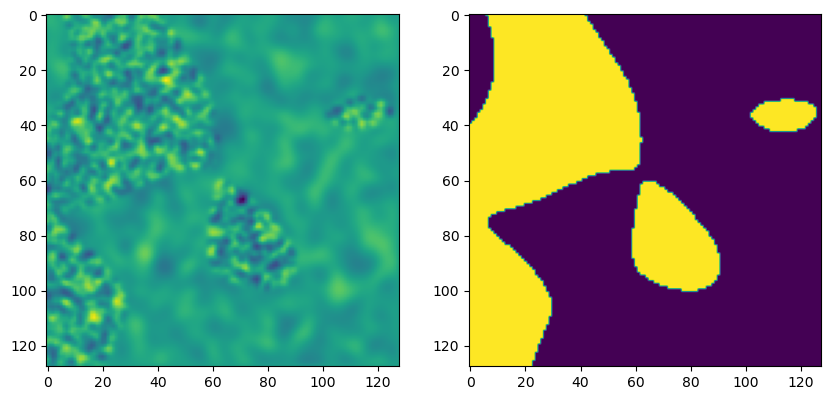

In [5]:
torch.manual_seed(0)
image, mask = generate_data(batch_size = 1, 
                            image_size=128,
                            sigma1=0.2,
                            sigma2=2.5, 
                            sigma=15, **factory_kwargs)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(image[0].permute(1,2,0).detach().cpu().numpy())
axes[1].imshow(mask[0].permute(1,2,0).detach().cpu().numpy())
# axes[2].imshow(b[0].permute(1,2,0).detach().cpu().numpy())
plt.show()

Note that the mask is also a image of 128x128 pixels (like the input image) but each pixel value is either 0 or 1 to identify the domain that contains itself.

In [6]:
print("image.shape: ", image.shape)
print("mask.shape: ", mask.shape)
print(mask[0])

image.shape:  torch.Size([1, 1, 128, 128])
mask.shape:  torch.Size([1, 1, 128, 128])
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.]]], device='cuda:0')


### 3.2 The role of $\sigma_1$ and $\sigma_2$
Now we keep the mask as above, but we change the value of $\sigma_1$ close to $\sigma_2$, to see how the data evolves. For each pair of images, we define the first image as a mixture of 2 sigmas very close together, and the second as a sigma a little further apart.

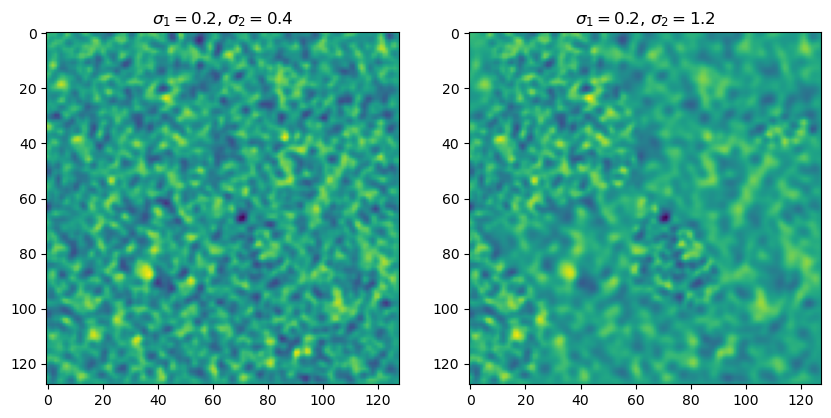

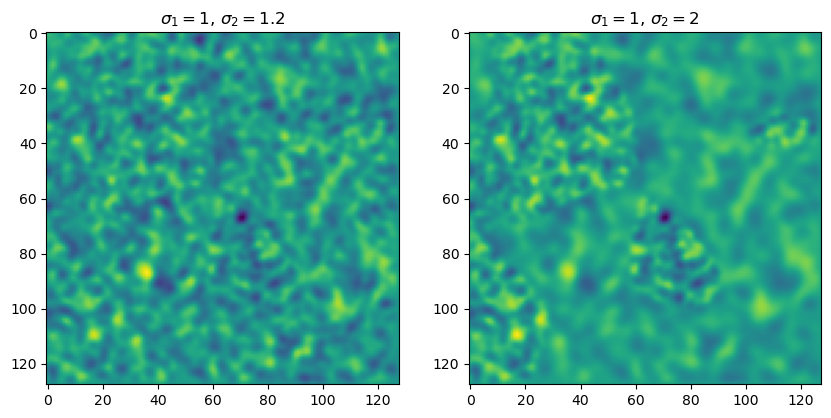

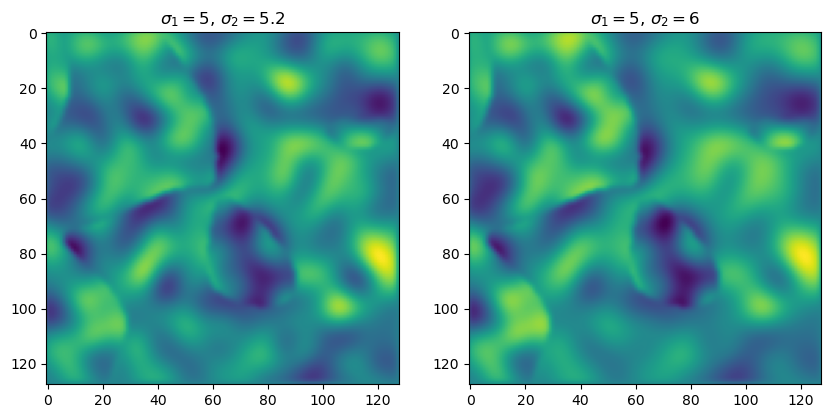

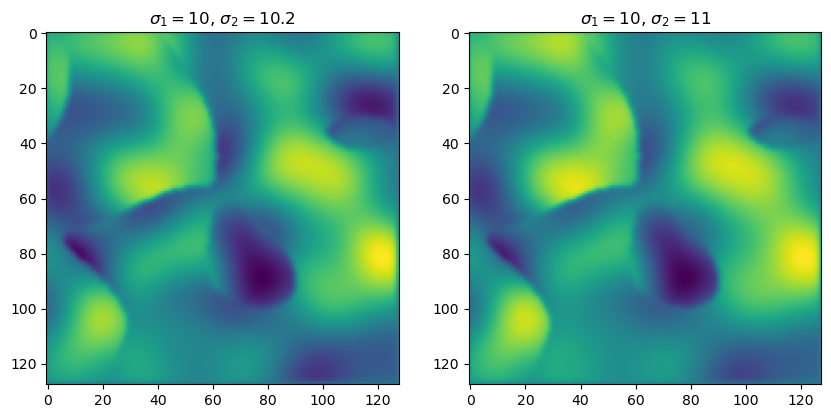

In [7]:
list_sigma1 = [0.2, 1, 5, 10]
for sigma1 in list_sigma1:
    torch.manual_seed(0)
    image1, mask1 = generate_data(batch_size = 1, 
                                  image_size=128,
                                  sigma1=sigma1,
                                  sigma2=sigma1+0.2, 
                                  sigma=15, **factory_kwargs)
    
    torch.manual_seed(0)
    image2, mask2 = generate_data(batch_size = 1, 
                                  image_size=128,
                                  sigma1=sigma1,
                                  sigma2=sigma1 + 1, 
                                  sigma=15, **factory_kwargs)

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(image1[0].permute(1,2,0).detach().cpu().numpy())
    axes[1].imshow(image2[0].permute(1,2,0).detach().cpu().numpy())
    axes[0].set_title("$\sigma_1 = $" + str(sigma1) + ", $\sigma_2 = $" + str(sigma1+0.2))
    axes[1].set_title("$\sigma_1 = $" + str(sigma1) + ", $\sigma_2 = $" + str(sigma1+1))
    plt.show()


We can see here, with $\sigma = 15$, that the further $\sigma_1$ and $\sigma_2$ are from $\sigma$, the more difficult it is to identify 2 distinct areas in the blending images. Furthermore, the further $\sigma_1$ and $\sigma_2$ are from each other, the more difficult it is also. We can conclude that $\sigma_1$ and $\sigma_2$ are used to control the complexity of the image to be segmented.

A more efficient way to generate a 2D Gaussian is in following, let have a look at this function and try to understand the difference.

In [8]:
def gaussian(image_size, sigma, **factory_kwargs):
    linspace = torch.linspace(-image_size/2, image_size/2, image_size, **factory_kwargs)
    distance = linspace[None,:] ** 2 + linspace[:,None] ** 2
    
    # Defining 4 Gaussian
    g = torch.exp(-distance / (2 * sigma**2))
    g = g / torch.sum(g)

    return g

### 3.3 Define the neural network

In this part, we define our very first Neural Network of which the architecture is described in the figure below. This is a simpler version of a well-known U-Net model. 

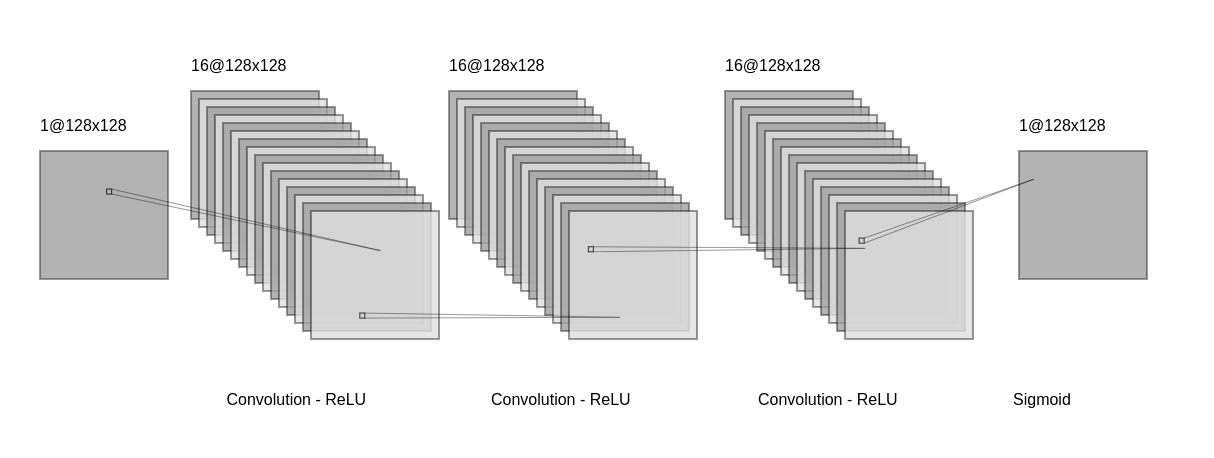

Briefly, we can explain this model as consisting of 1 input, 1 output, 1 encoder layer (layer 2)  and 1 decoder layer (layer 3) connected by a bridge layer (layer 2).
- Encoder - Layer 1 : Convolutional Layer (Conv2D) with ReLU activation.
- Bottleneck: A layer in the middle that captures the most abstract features. It typically involves additional convolutional layers.
- Decoder - Layer 3 : Convolutional Layer with ReLU activation. 
- Layer 4 (Final Output) : Convolutional Layer with a sigmoid activation function to produce the final segmentation mask.

In [9]:
class MyFirtsCNN(nn.Module):
    def __init__(self, num_channels=16, kernel_size = 5, bias=True):
        super().__init__()

        self.activation = nn.ReLU()
        self.bn = nn.BatchNorm2d(num_channels)
        self.bias = bias
        self.kernel_size = kernel_size
        self.pad = int((self.kernel_size - 1) / 2)
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=num_channels,
                kernel_size=self.kernel_size,
                stride=1,
                padding=self.pad,
                bias=bias,
            ),
            self.activation,
            self.bn
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=num_channels,
                out_channels=num_channels,
                kernel_size=self.kernel_size,
                stride=1,
                padding=self.pad,
                bias=self.bias,
            ),
            self.activation,
            self.bn
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels=num_channels,
                out_channels=num_channels,
                kernel_size=self.kernel_size,
                stride=1,
                padding=self.pad,
                bias=self.bias,
            ),
            self.activation,
            self.bn
        )

        self.out = nn.Conv2d(
                in_channels=num_channels,
                out_channels=1,
                kernel_size=self.kernel_size,
                stride=1,
                padding=self.pad,
                bias=self.bias,
        )

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        x3 = self.conv3(x2)
        output = torch.sigmoid(self.out(x3))
        return output


##### Question: How many layers do we have in the network? What are the activation functions?

- There are 4 layers in the networks, 3 hidden layers and 1 output layer.
- For each hidden layer, the activation function is ReLU, which is defined as following : 
$$ \text{ReLU}(x) = \text{max}(0,x)$$

##### Question : Explain why we have a `sigmoid` activation at the end of the network? Write the training optimization problem.
- `Sigmoid` is used for the last layer because the response is binary, either 0 or 1, to determine whether this pixel belongs to this class or not. 

The optimization problem can be described as following: Given $D = \left \{(X_i, Y_i ), i=1,..,n \right \}$ the dataset consisting of image-label pairs where $X_i\in \mathbb{R}^{N\times N}$ the input image and $Y_i\in \mathbb{R}^{N\times N}$ the corresponding ground truth segmentation mask; $\theta$ the vector of parameters in the U-Net, we need to find the vector pf parameter $\theta$ such tha: 
$$\theta = \text{argmin} \frac{1}{n} \sum_{i=1}^{n}\mathcal{L}(f_{\theta}(X_i),Y_i)$$
where 
- $f_{\theta}$ is the U-Net model with parameter $\theta$
- $\mathcal{L}$ is the chosen loss function (e.g cross-entropy, dice coefficient loss, etc)

The structure of the function $f_{\theta}$ can be described as following : 

In [10]:
model = MyFirtsCNN(num_channels=16, kernel_size = 5)
model

MyFirtsCNN(
  (activation): ReLU()
  (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (out): Conv2d(16, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
)

#### Number of parameters in our model
To calculate the number of parameters, we sum the number of parameters in each layer. For each layer we have :
$$ N_{param} = N_{input} \times N_{output} \times Kernel\_size² + N_{biais} + 2 \times N_{BatchNorm2d}$$
Especially for the in layer BatchNorm2d, we difine this layer only one times at the beginning of the network, so we just need to count it one time.

The number of parameters in each layer is shown below :

In [58]:
n1 = 1*16*25+16 +16*2
n2 = 16*16*25+16
n3 = 16*16*25+16
n4 = 16*1*25+1
print( 'Num of first hidden layer with BatchNorm2d layer: '+ str(n1))
print( 'Num of second hidden layer: '+ str(n2))
print( 'Num of third hidden layer: '+ str(n3))
print( 'Num of fourth hidden layer: '+ str(n4))
print( 'Manually counted number of parameters: '+ str(n1+n2+n3+n4))

# Check it up with pytorch function to count the number of parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print("\nModel number of parameters: ", count_parameters(model))

Num of first hidden layer with BatchNorm2d layer: 448
Num of second hidden layer: 6416
Num of third hidden layer: 6416
Num of fourth hidden layer: 401
Manually counted number of parameters: 13681

Model number of parameters:  13681


- Verify where is the model is stocked 

In [12]:
# By default, the model (i.e., the trainable parameters) is stored in CPU
print(next(model.parameters()).device)
# You have to push your to GPU if you want to use GPU
model = model.to(device)
print(next(model.parameters()).device)


cpu
cuda:0


Our model is running in GPU for sure.

#### Verify the model output shape and input shape?

In [13]:
print("Input shape: ", image.shape)
model_shape = model

# Let's print it
print("Output shape: ", model_shape(image).shape)

Input shape:  torch.Size([1, 1, 128, 128])
Output shape:  torch.Size([1, 1, 128, 128])


Because we need the output to be a mask corresponding to the input image, so the output is also an image of the same size as the input image, each pixel of the output will be a number, either 1 or 2, indicating the $\Omega_1$ or $\Omega_2$ domain to which the corresponding pixel of the input image belongs.

### 3.4. Define your optimization algorithm

The optimization algorithms are defined in `torch.optim`. We need to pass all the trainable parameters to the optimizer, along with other hyperparameters such as the learning rate, etc

In [14]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)

/home/duy_ordi/miniforge3/envs/optim/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 3.5 Training the model using SGD optimizer

Define your training hyperparameters

In [15]:
from tqdm.auto import tqdm

Below is an example of how to train a neural network. 

Iteration: 1000, Loss: 1.3996e-01:  10%|▉         | 997/10000 [00:19<02:49, 53.06it/s]

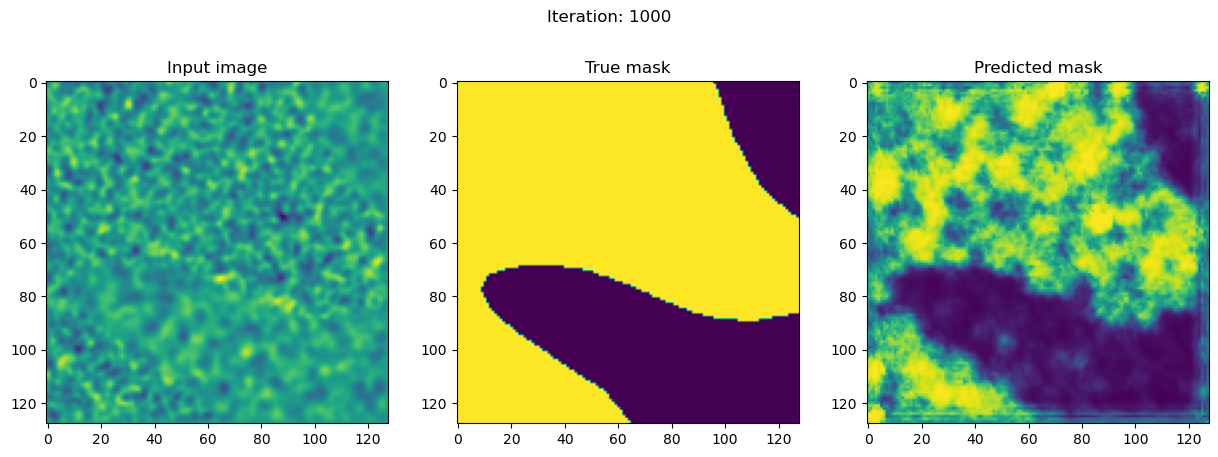

Iteration: 2000, Loss: 9.6638e-02:  20%|█▉        | 1999/10000 [00:38<02:29, 53.41it/s]

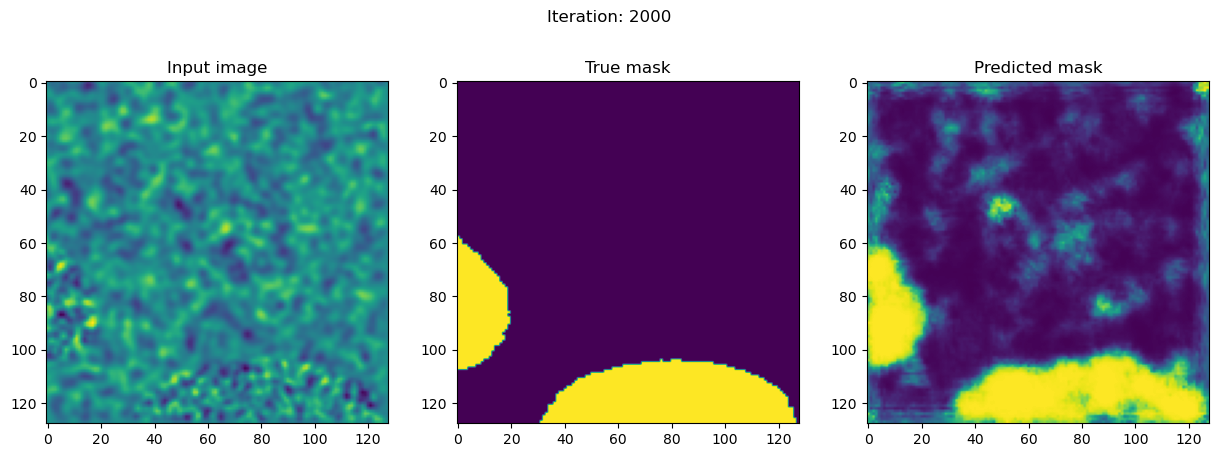

Iteration: 3000, Loss: 7.6834e-02:  30%|██▉       | 2995/10000 [00:57<02:10, 53.50it/s]

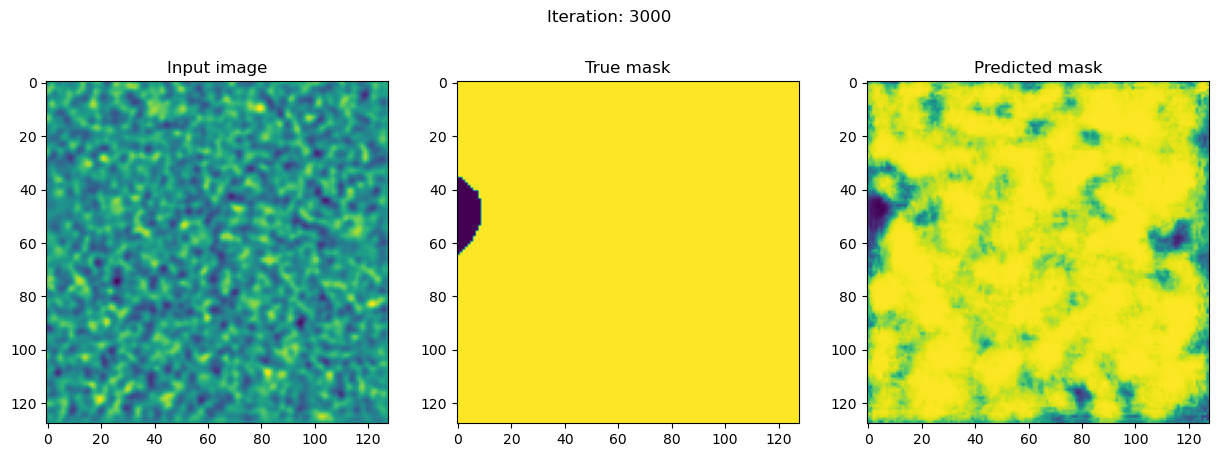

Iteration: 4000, Loss: 6.5161e-02:  40%|███▉      | 3997/10000 [01:16<01:53, 52.86it/s]

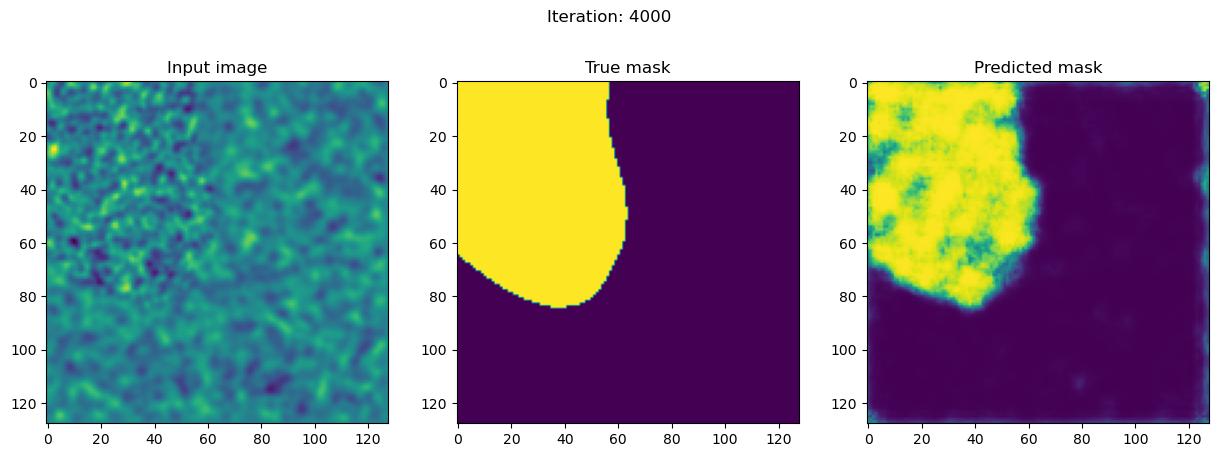

Iteration: 5000, Loss: 5.7315e-02:  50%|████▉     | 4999/10000 [01:35<01:33, 53.26it/s]

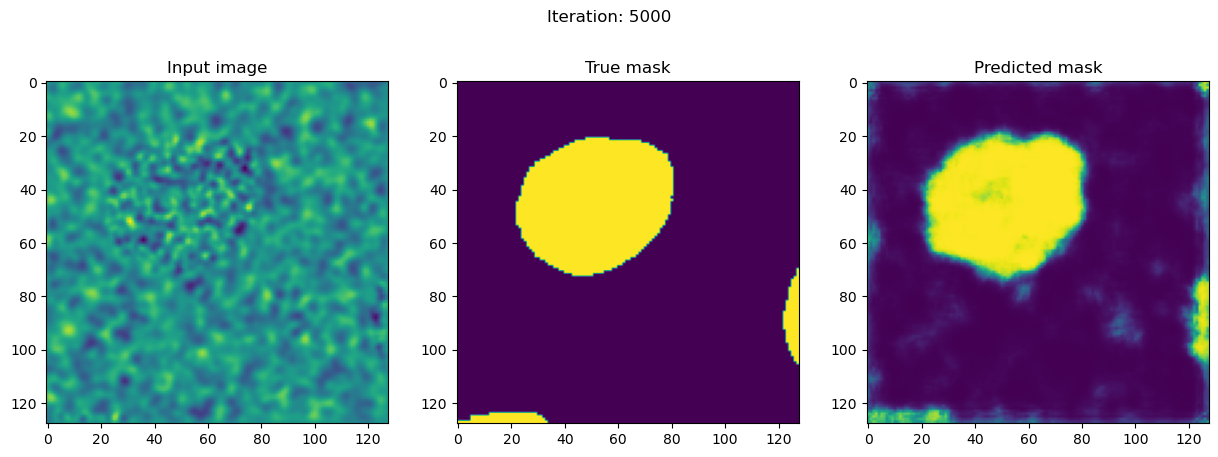

Iteration: 6000, Loss: 5.1751e-02:  60%|█████▉    | 5995/10000 [01:54<01:14, 53.46it/s]

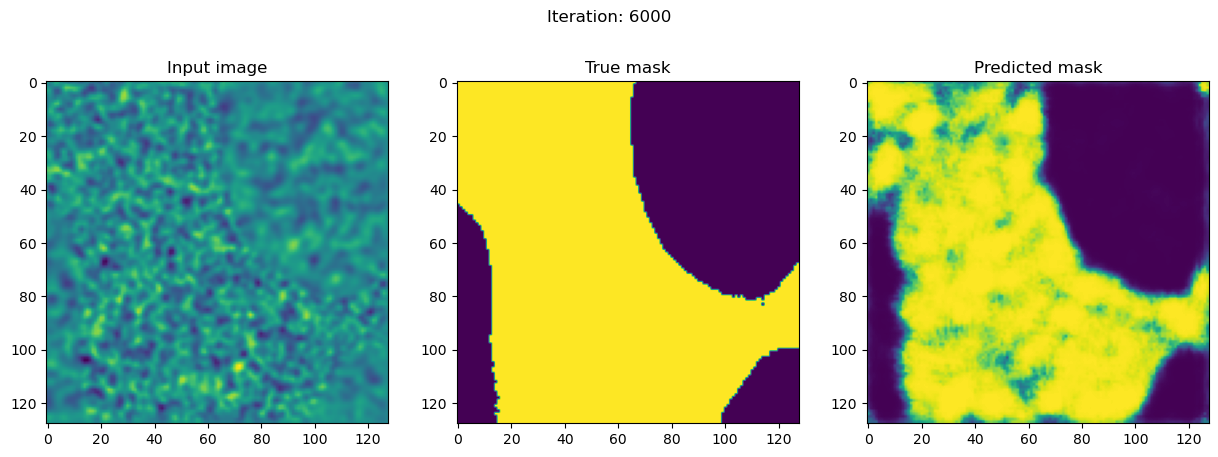

Iteration: 7000, Loss: 4.7524e-02:  70%|██████▉   | 6997/10000 [02:13<00:56, 52.84it/s]

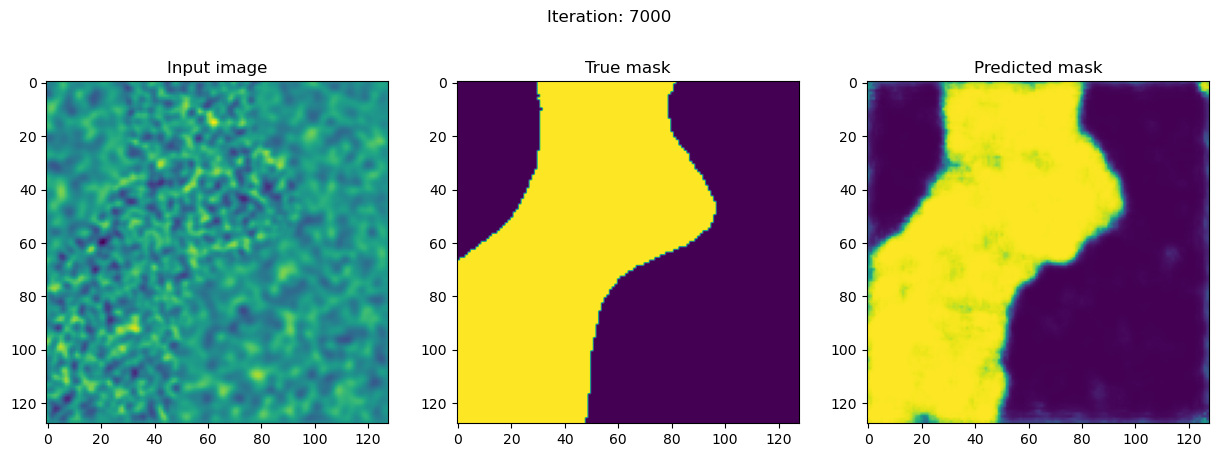

Iteration: 8000, Loss: 4.4245e-02:  80%|███████▉  | 7999/10000 [02:33<00:37, 52.72it/s]

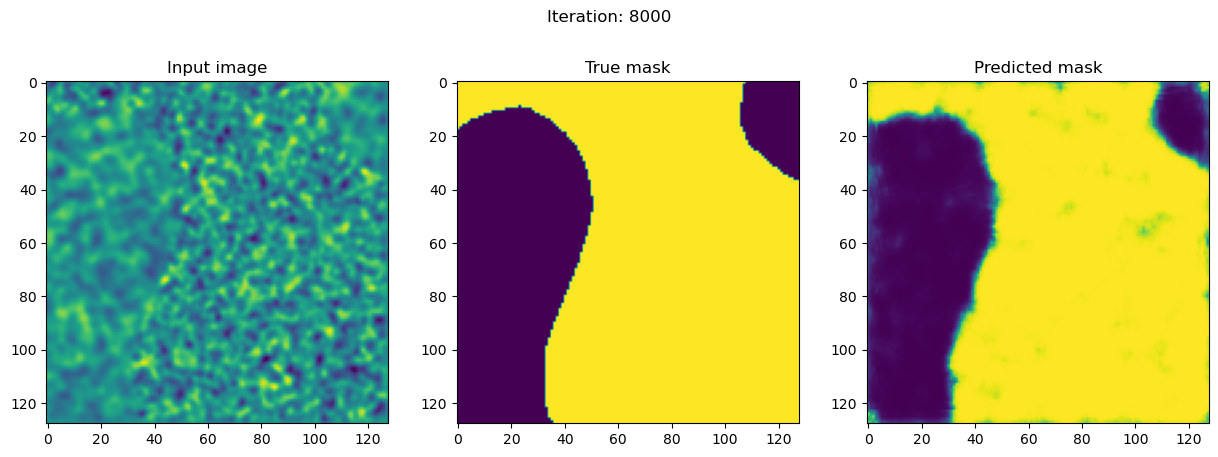

Iteration: 9000, Loss: 4.1612e-02:  90%|████████▉ | 8995/10000 [02:52<00:19, 52.32it/s]

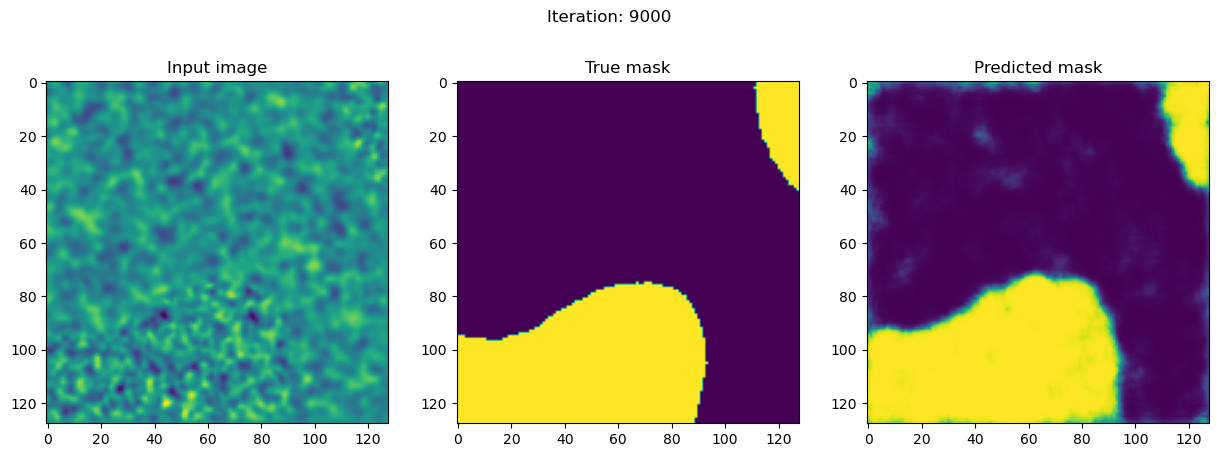

Iteration: 10000, Loss: 3.9440e-02: 100%|█████████▉| 9997/10000 [03:11<00:00, 52.81it/s]

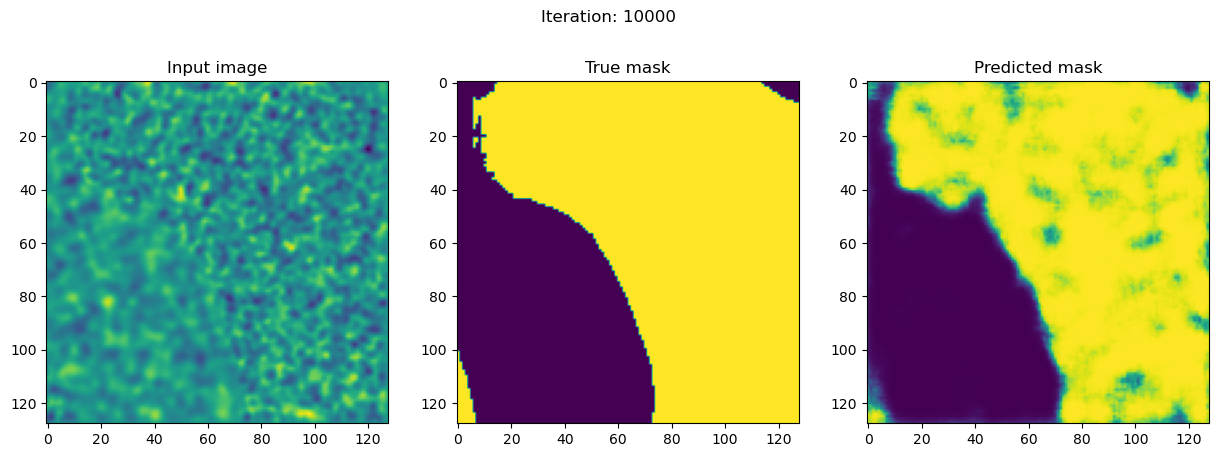

Iteration: 10000, Loss: 3.9440e-02: 100%|██████████| 10000/10000 [03:11<00:00, 52.14it/s]


In [16]:
num_train_iteration = 10000
batch_size = 8
display_prediction_every = 1000
image_size = 128
sigma1 = 0.2
sigma2 = 1.2
sigma = image_size / 5


t = tqdm(range(num_train_iteration))
avg_loss = 0
loss_tracking = []

for i in t:
    x, omega_1 = generate_data(batch_size, image_size, sigma1, sigma2, sigma, **factory_kwargs)

    # Step 1: We need to set the gradients to zero before starting to do backpropragation
    optimizer.zero_grad()

    # Step 2: Forward pass
    predicted_omega_1 = model(x)

    # Step 3: Compute loss
    loss = torch.mean((predicted_omega_1 - omega_1) ** 2 )

    # Step 4: Backward pass to compute the gradients
    loss.backward()

    # Step 5: Update the parameters
    optimizer.step()

    # Tracking 
    avg_loss += loss.item()
    loss_tracking.append(avg_loss / (i + 1))
    t.set_description(f"Iteration: {i + 1}, Loss: {avg_loss / (i + 1):.4e}")

    if (i + 1) % display_prediction_every == 0:
        # Turn off the gradient tracking for better performance
        # since we don't need to track the gradients for this step
        with torch.no_grad():
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))
            
            axes[0].imshow(x[0,0].detach().cpu().numpy())
            axes[0].set_title("Input image")

            axes[1].imshow(omega_1[0,0].detach().cpu().numpy())
            axes[1].set_title("True mask")

            axes[2].imshow(predicted_omega_1[0,0].detach().cpu().numpy())
            axes[2].set_title("Predicted mask")
            plt.suptitle("Iteration: {}".format(i + 1))
            plt.show()

As we can see here, the model is not predicting so well out masks. There are many confused spots in 2 distinct domain. We take a look at hee evolution of the average loss over the training process.

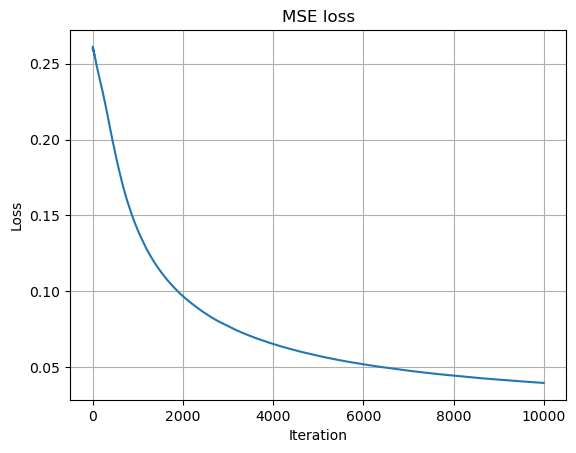

In [17]:
plt.plot(loss_tracking)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("MSE loss")
plt.grid()
plt.show()

#### Loss function 
In the training process above, we used a very simple loss function which is Mean Square Error (MSE or Loss L2), which is defined as:
$$ \text{MSE} = \frac{1}{n}\sum_{i=0}^{n}||\hat{\omega_1} - \omega_1||_2^2 $$
Besides, we are considering a binary image segmentation problem, so we can use Binary Cross Entropy as loss function, which is defined as :  $$\mathcal{L}(\hat{\omega_1} ,\omega_1) = \sum_{i=0}^{128\times128} \left ( -\omega_{1,i}\text{log}(\hat{\omega_{1,i}}) - (1-\omega_{1,i})\text{log}(1-\hat{\omega_{1,i}})\right ) $$ 

Moreover, another very widely used loss function is dice coefficient: $DL(\hat{\omega_{1,i}},\omega_{1,i}) = 1-\frac{2\omega_{1,i}\hat{\omega_{1,i}}+1}{\omega_{1,i}+\hat{\omega_{1,i}}+1}$. 

In the above work, we trained the model with SGD Optimizer at the lr = 0.001. The model does not appear to work well though, so we are suspicious about the learning rate value as well as the hyperparameters. 

#### Saving the trained model for further use 

In [18]:
state_dict = model.state_dict()
torch.save(state_dict, "best_model.pt")

## 4. Train the best model ever

- Try different optimizers and learning rates (see `torch.optim` in [this link](https://pytorch.org/docs/stable/optim.html#algorithms) ). Compare the performance. 
- What happens if the learning rate is too large? too small?
- How to evaluate the performance of your model?
- With a limit training time, try to train your best model.

In the previous section, we concepted a simple U-Net model of 4 layers. We trained this model using SGD optimizers at the learning rate 0.001 but it did not perform so well. In this section, we try to tune the learning rate in this model to find out the best one, then try different optimizers in order to obtain the best model as possible for this image segmentation task.  

### 4.1. Learning rate tuning
Now we consider different values of learning rate and compare the performance of the model with SGD optimizer.

In [19]:
lr = 0.1
batch_size = 8
num_epochs = 100

model_lr = MyFirtsCNN(num_channels=16, kernel_size = 5).to(device)
optimizer = torch.optim.Adam(model_lr.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
lambda1 = lambda epoch: 0.95 ** epoch 
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)

print(optimizer.state_dict())   

for epoch in range(1,num_epochs):
    loss = 0
    for i in range(0, 100):
        x, omega_1 = generate_data(batch_size, image_size, sigma1, sigma2, sigma, **factory_kwargs)
        optimizer.zero_grad()
        output = model_lr(x)
        loss = criterion(output, omega_1)
        loss.backward()
    optimizer.step()
    scheduler.step()
    print('epoch {}, loss {}'.format(epoch, loss.item()))

trainer = pl.Trainer(gpus=1, max_epochs=10)

{'state': {}, 'param_groups': [{'lr': 0.1, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False, 'maximize': False, 'foreach': None, 'capturable': False, 'differentiable': False, 'fused': None, 'initial_lr': 0.1, 'params': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]}]}
epoch 1, loss -0.0
epoch 2, loss -0.0
epoch 3, loss -0.0
epoch 4, loss -0.0
epoch 5, loss -0.0
epoch 6, loss -0.0
epoch 7, loss -0.0
epoch 8, loss -0.0
epoch 9, loss -0.0
epoch 10, loss -0.0
epoch 11, loss -0.0
epoch 12, loss -0.0
epoch 13, loss -0.0
epoch 14, loss -0.0
epoch 15, loss -0.0
epoch 16, loss -0.0
epoch 17, loss -0.0
epoch 18, loss -0.0
epoch 19, loss -0.0
epoch 20, loss -0.0
epoch 21, loss -0.0
epoch 22, loss -0.0
epoch 23, loss -0.0
epoch 24, loss -0.0
epoch 25, loss -0.0
epoch 26, loss -0.0
epoch 27, loss -0.0
epoch 28, loss -0.0
epoch 29, loss -0.0
epoch 30, loss -0.0
epoch 31, loss -0.0
epoch 32, loss -0.0
epoch 33, loss -0.0
epoch 34, loss -0.0
epoch 35, loss -0.0
epoch 36, loss -0.0
epoch 37, lo

In the above chunk we tried to use the learnig rate finder of the scheduler but it did not work. So we turn to tune it manually. Here we define many different values for learning rate, ranging from 0.0001 to 1 and then display the track of average loss function for each of them. We fix the max number of iteration to 1000 steps and try to compare the perfomance of each model basing on their average loss function.

In [44]:
# Function to tune the learning rate
def tune_learning_rate(model, num_train_iteration, batch_size, lr_values):
    # Initialize tracking variables
    loss_tracking_lr = {lr: [] for lr in lr_values}

    for lr in lr_values:
        # Initialize the model and optimizer
        model = MyFirtsCNN(num_channels=16, kernel_size = 5).to(device)
        optimizer = optim.Adam(model.parameters(), lr=lr)

        t = tqdm(range(num_train_iteration))
        avg_loss = 0
        loss_tracking = []

        for i in t:
            x, omega_1 = generate_data(batch_size, image_size, sigma1, sigma2, sigma, **factory_kwargs)

            optimizer.zero_grad()
            predicted_omega_1 = model(x)
            loss = torch.mean((predicted_omega_1 - omega_1) ** 2)
            loss.backward()
            optimizer.step()

            avg_loss += loss.item()
            loss_tracking.append(avg_loss / (i + 1))
            t.set_description(f"Iteration: {i + 1}, Loss: {avg_loss / (i + 1):.4e}")

        # Save the loss tracking for this learning rate
        loss_tracking_lr[lr] = loss_tracking

    return loss_tracking_lr

# Define a range of learning rates to try
lr_values_to_try = [0.00001, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 5.0]

# Perform learning rate tuning
loss_tracking_lr_results = tune_learning_rate(model=MyFirtsCNN(), num_train_iteration=1000,
                                               batch_size=batch_size, lr_values=lr_values_to_try)

Iteration: 1000, Loss: 5.0313e-01: 100%|██████████| 1000/1000 [00:18<00:00, 53.59it/s]


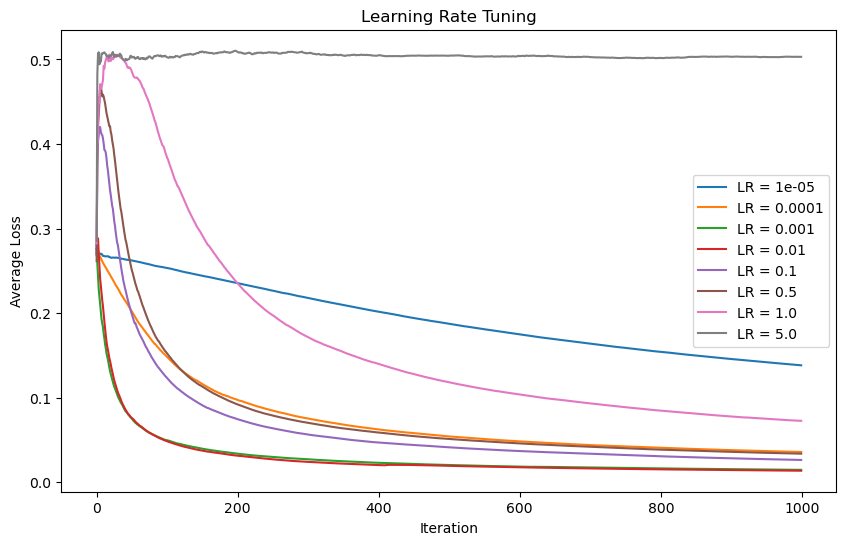

In [45]:
# Plot the results for each learning rate
plt.figure(figsize=(10, 6))
for lr, loss_tracking in loss_tracking_lr_results.items():
    plt.plot(loss_tracking, label=f'LR = {lr}')

plt.title('Learning Rate Tuning')
plt.xlabel('Iteration')
plt.ylabel('Average Loss')
plt.legend()
plt.show()

We can see here the performance of the learning rates which range from 0.001 to 0.1 perform the best among all (green and red curves at the bottom). When the learning rate value is too small (yellow and blue curves) or when it is too high (brown and violet curves), the average loss function tends to be much larger, so the result given by respective model is clearly worse (In the figure we see that model performs worse at higher learning rates than smaller ones). With too big learning rate (gray curve), the loss takes very high value and even does not mean to converge. 

### 4.2. Metrics for model evaluation 

One commonly used metric for evaluating Image Segmentation model is the **Intersection over Union (IoU)**, also known as the Jaccard Index.
$$ IoU = \frac{\text{Area of overlap}}{\text{Area of Union}}$$
IoU ranges from 0 to 1, where 0 indicates no overlap between the predicted and ground truth segments, and 1 indicates perfect overlap. Higher IoU values indicate better segmentation performance.

In [43]:
predicted_omega_1[predicted_omega_1 < 0.1] = 0
predicted_omega_1[predicted_omega_1 > 0.9] = 1
print("Precision: ", (predicted_omega_1 == omega_1).sum() / (batch_size * image_size **2))

Precision:  tensor(0.8326, device='cuda:0')


We see here the IoU ratio is 0.8326 so we can say that the percentage of well segmented pixel is 83.26%. The higher this percentage is, the better the model perform. 

Another metric can be used is the **Precision, Recall and F1 Score**, which is given by the notation of True Positive (TP), True Negative (TN), False Positive (FP) and False Negative (FN). \\

|                     | Actual Class 0 | Actual Class 1 |
|---------------------|----------------|----------------|
| **Predicted Class 0** | TN             | FP             |
| **Predicted Class 1** | FN             | TN             |

\
The **Precision, Recall and F1 Score** is defined by : 
$$\text{Precision} = \frac{TP}{FP+FP}, \text{Recall}=\frac{TP}{TP + FN}, \text{F1} = \frac{2 \times \text{Precision}\times \text{Recall}}{\text{Precision}+\text{Recall}}$$

In fact, IoU is also based on this confusion table. Indeed, we can see that $IoU = \frac{TP}{TP + FN + FP}$. We can use this metric for further works.

### 4.3 Choice of algorithm 

Now we turn to choose the best optimizer for out model. We will try 4 algorithms of optimization : SGD, SGD with momentum, RMSProp and ADAM, under the same conditions (same learning rate 0.001 which gives the smallest cost, under 1000 iterations and in a same periode of time - below 1 minute) then compare their perfomance. The metric used for the evaluation here is the IoU ratio. 

- Using ADAM Optimizer

Iteration: 1000, Loss: 1.4081e-02: 100%|█████████▉| 995/1000 [00:18<00:00, 53.20it/s]

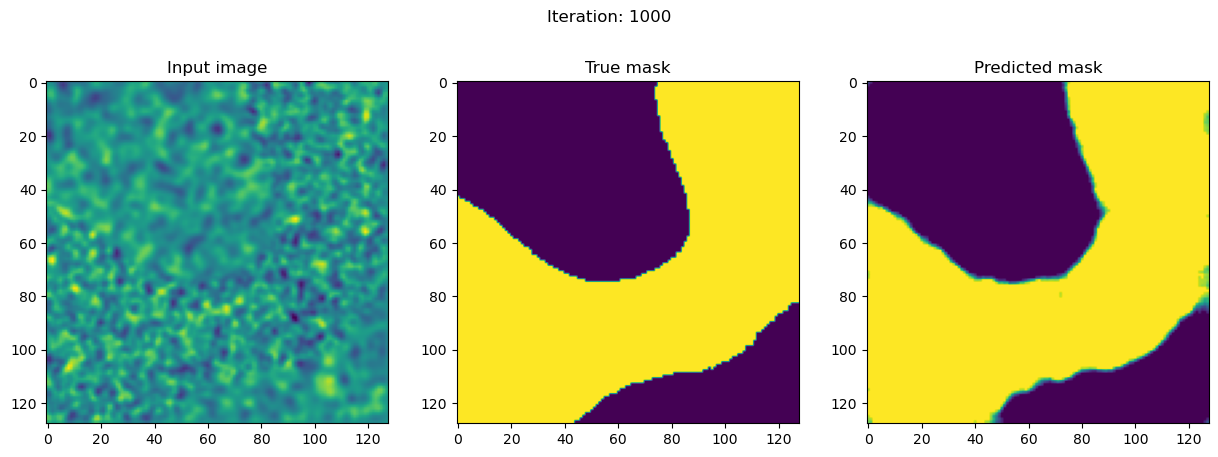

Iteration: 1000, Loss: 1.4081e-02: 100%|██████████| 1000/1000 [00:19<00:00, 52.05it/s]


In [52]:
num_train_iteration = 1000
display_prediction_every = 1000

model_adam = MyFirtsCNN(num_channels=16, kernel_size = 5).to(device)
optimizer_adam = torch.optim.Adam(model_adam.parameters(), lr=0.001)

t = tqdm(range(num_train_iteration))
avg_loss_adam = 0
loss_tracking_adam = []
precision_tracking_adam = []
precision = 0

for i in t:
    x, omega_1 = generate_data(batch_size, image_size, sigma1, sigma2, sigma, **factory_kwargs)
    optimizer_adam.zero_grad()
    predicted_omega_1 = model_adam(x)
    loss = torch.mean((predicted_omega_1 - omega_1) ** 2 )
    loss.backward()
    optimizer_adam.step()

    # Tracking 
    avg_loss_adam += loss.item()
    loss_tracking_adam.append(avg_loss_adam / (i + 1))
    t.set_description(f"Iteration: {i + 1}, Loss: {avg_loss_adam / (i + 1):.4e}")

    # Average precision of the prediction
    predicted_omega_1[predicted_omega_1 < 0.1] = 0
    predicted_omega_1[predicted_omega_1 > 0.9] = 1
    precision = (precision * i + (predicted_omega_1 == omega_1).sum() / (batch_size * image_size **2))/(i + 1)
    precision_tracking_adam.append(precision)

    if (i + 1) % display_prediction_every == 0:
        # Turn off the gradient tracking for better performance
        # since we don't need to track the gradients for this step
        with torch.no_grad():
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))
            
            axes[0].imshow(x[0,0].detach().cpu().numpy())
            axes[0].set_title("Input image")

            axes[1].imshow(omega_1[0,0].detach().cpu().numpy())
            axes[1].set_title("True mask")

            axes[2].imshow(predicted_omega_1[0,0].detach().cpu().numpy())
            axes[2].set_title("Predicted mask")
            plt.suptitle("Iteration: {}".format(i + 1))
            plt.show()

Lastest precision:  tensor(0.9182, device='cuda:0')


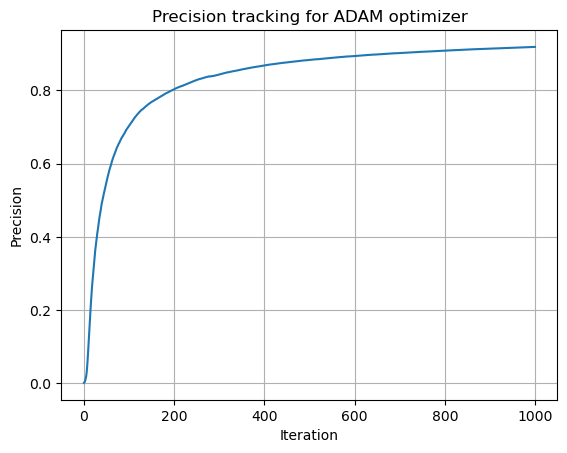

In [47]:
# Precision tracking 
print("Lastest precision: ", precision)
precision_tracking_adam_numpy = [tensor.cpu().numpy() for tensor in precision_tracking_adam]
plt.plot(precision_tracking_adam_numpy)
plt.xlabel("Iteration")
plt.ylabel("Precision")
plt.title("Precision tracking for ADAM optimizer")
plt.grid()
plt.show()

Iteration: 1000, Loss: 1.3566e-02:  99%|█████████▉| 994/1000 [00:19<00:00, 52.17it/s]

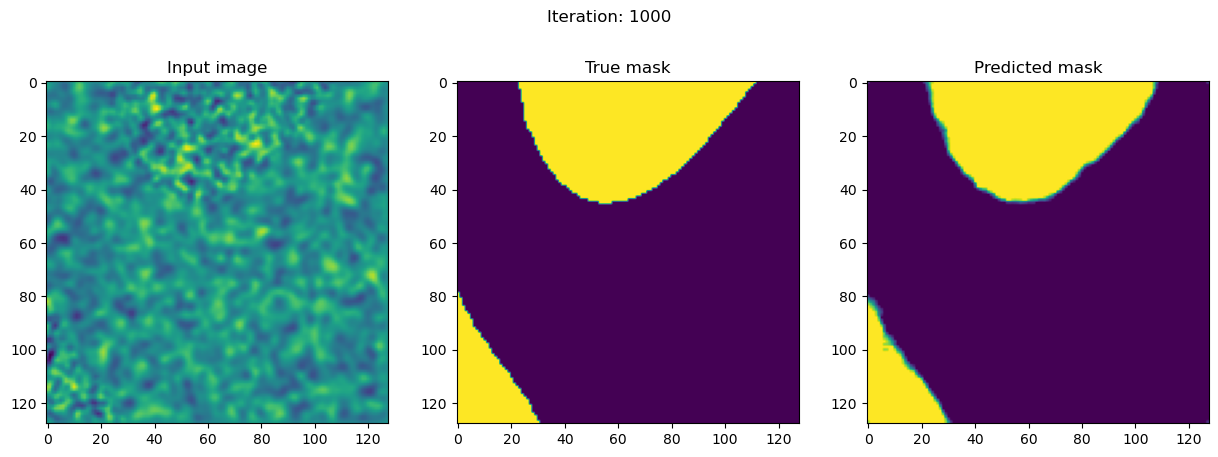

Iteration: 1000, Loss: 1.3566e-02: 100%|██████████| 1000/1000 [00:19<00:00, 51.83it/s]


In [48]:
model_rmsprop = MyFirtsCNN(num_channels=16, kernel_size = 5).to(device)
optimizer_rmsprop = torch.optim.RMSprop(model_rmsprop.parameters(), lr=0.001)

t = tqdm(range(num_train_iteration))
avg_loss_rmsprop = 0
loss_tracking_rmsprop = []
precision_tracking_rmsprop = []
precision = 0

for i in t:
    x, omega_1 = generate_data(batch_size, image_size, sigma1, sigma2, sigma, **factory_kwargs)
    optimizer_rmsprop.zero_grad()
    predicted_omega_1 = model_rmsprop(x)
    loss = torch.mean((predicted_omega_1 - omega_1) ** 2 )
    loss.backward()
    optimizer_rmsprop.step()

    # Tracking 
    avg_loss_rmsprop += loss.item()
    loss_tracking_rmsprop.append(avg_loss / (i + 1))
    t.set_description(f"Iteration: {i + 1}, Loss: {avg_loss_rmsprop / (i + 1):.4e}")

    # Average precision of the prediction
    predicted_omega_1[predicted_omega_1 < 0.1] = 0
    predicted_omega_1[predicted_omega_1 > 0.9] = 1
    precision = (precision * i + (predicted_omega_1 == omega_1).sum() / (batch_size * image_size **2))/(i + 1)
    precision_tracking_rmsprop.append(precision)

    if (i + 1) % display_prediction_every == 0:
        # Turn off the gradient tracking for better performance
        # since we don't need to track the gradients for this step
        with torch.no_grad():
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))
            
            axes[0].imshow(x[0,0].detach().cpu().numpy())
            axes[0].set_title("Input image")

            axes[1].imshow(omega_1[0,0].detach().cpu().numpy())
            axes[1].set_title("True mask")

            axes[2].imshow(predicted_omega_1[0,0].detach().cpu().numpy())
            axes[2].set_title("Predicted mask")
            plt.suptitle("Iteration: {}".format(i + 1))
            plt.show()

Lastest precision:  tensor(0.9356, device='cuda:0')


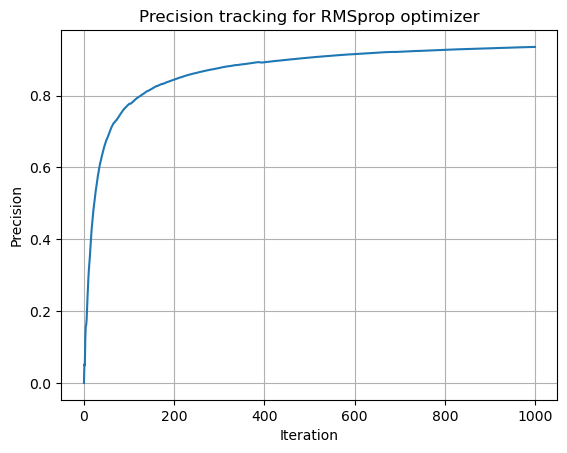

In [49]:
# Precision tracking 
print("Lastest precision: ", precision)
precision_tracking_rmsprop_numpy = [tensor.cpu().numpy() for tensor in precision_tracking_rmsprop]
plt.plot(precision_tracking_rmsprop_numpy)
plt.xlabel("Iteration")
plt.ylabel("Precision")
plt.title("Precision tracking for RMSprop optimizer")
plt.grid()
plt.show()

Iteration: 1000, Loss: 3.8248e-02: 100%|█████████▉| 995/1000 [00:18<00:00, 53.11it/s]

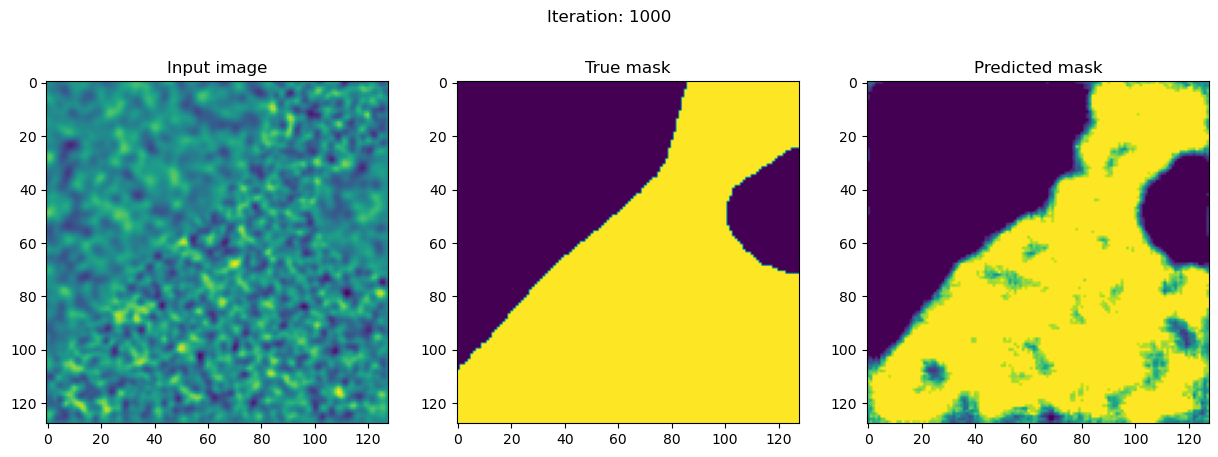

Iteration: 1000, Loss: 3.8248e-02: 100%|██████████| 1000/1000 [00:19<00:00, 51.98it/s]


In [50]:
model_SGDmomentum = MyFirtsCNN(num_channels=16, kernel_size = 5).to(device)
optimizer_SGDmomentum = torch.optim.SGD(model_SGDmomentum.parameters(), lr=0.001, momentum=0.9)

t = tqdm(range(num_train_iteration))
avg_loss_SGDmomentum = 0
loss_tracking_SGDmomentum = []
precision_tracking_SGDmomentum = []
precision = 0

for i in t:
    x, omega_1 = generate_data(batch_size, image_size, sigma1, sigma2, sigma, **factory_kwargs)
    optimizer_SGDmomentum.zero_grad()
    predicted_omega_1 = model_SGDmomentum(x)
    loss = torch.mean((predicted_omega_1 - omega_1) ** 2 )
    loss.backward()
    optimizer_SGDmomentum.step()

    # Tracking 
    avg_loss_SGDmomentum += loss.item()
    loss_tracking_SGDmomentum.append(avg_loss_SGDmomentum / (i + 1))
    t.set_description(f"Iteration: {i + 1}, Loss: {avg_loss_SGDmomentum / (i + 1):.4e}")

    # Average precision of the prediction
    predicted_omega_1[predicted_omega_1 < 0.1] = 0
    predicted_omega_1[predicted_omega_1 > 0.9] = 1
    precision = (precision * i + (predicted_omega_1 == omega_1).sum() / (batch_size * image_size **2))/(i + 1)
    precision_tracking_SGDmomentum.append(precision)

    if (i + 1) % display_prediction_every == 0:
        # Turn off the gradient tracking for better performance
        # since we don't need to track the gradients for this step
        with torch.no_grad():
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))
            
            axes[0].imshow(x[0,0].detach().cpu().numpy())
            axes[0].set_title("Input image")

            axes[1].imshow(omega_1[0,0].detach().cpu().numpy())
            axes[1].set_title("True mask")

            axes[2].imshow(predicted_omega_1[0,0].detach().cpu().numpy())
            axes[2].set_title("Predicted mask")
            plt.suptitle("Iteration: {}".format(i + 1))
            plt.show()

Lastest precision:  tensor(0.7434, device='cuda:0')


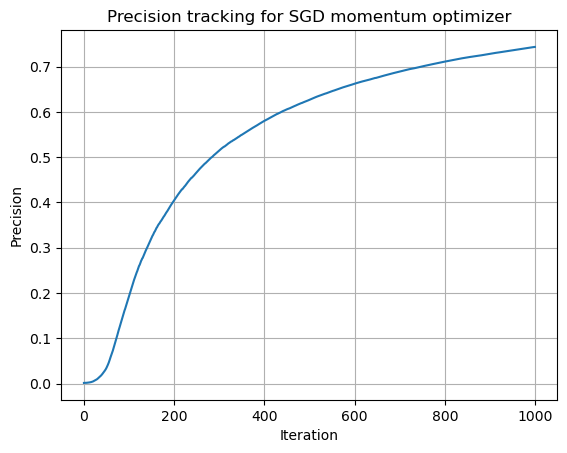

In [51]:
# Precision tracking for SGD momentum
print("Lastest precision: ", precision)
precision_tracking_SGDmomentum_numpy = [tensor.cpu().numpy() for tensor in precision_tracking_SGDmomentum]
plt.plot(precision_tracking_SGDmomentum_numpy)
plt.xlabel("Iteration")
plt.ylabel("Precision")
plt.title("Precision tracking for SGD momentum optimizer")
plt.grid()
plt.show()

Iteration: 1000, Loss: 4.5060e-02: 100%|██████████| 1000/1000 [00:19<00:00, 52.46it/s]


Lastest precision:  tensor(0.7185, device='cuda:0')


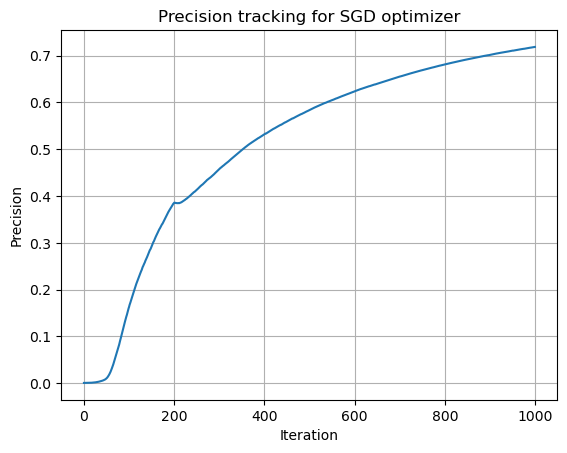

In [40]:
model_SGD = MyFirtsCNN(num_channels=16, kernel_size = 5).to(device)
optimizer_SGD  = torch.optim.SGD(model_SGD .parameters(), lr=0.001, momentum=0.9)

t = tqdm(range(num_train_iteration))
avg_loss_SGD = 0
loss_tracking_SGD = []
precision_tracking_SGD = []
precision = 0

for i in t:
    x, omega_1 = generate_data(batch_size, image_size, sigma1, sigma2, sigma, **factory_kwargs)
    optimizer_SGD.zero_grad()
    predicted_omega_1 = model_SGD(x)
    loss = torch.mean((predicted_omega_1 - omega_1) ** 2 )
    loss.backward()
    optimizer_SGD.step()

    # Tracking 
    avg_loss_SGD += loss.item()
    loss_tracking_SGD.append(avg_loss_SGD / (i + 1))
    t.set_description(f"Iteration: {i + 1}, Loss: {avg_loss_SGD / (i + 1):.4e}")

    # Average precision of the prediction
    predicted_omega_1[predicted_omega_1 < 0.1] = 0
    predicted_omega_1[predicted_omega_1 > 0.9] = 1
    precision = (precision * i + (predicted_omega_1 == omega_1).sum() / (batch_size * image_size **2))/(i + 1)
    precision_tracking_SGD.append(precision)

# Precision tracking for SGD momentum
print("Lastest precision: ", precision)
precision_tracking_SGD_numpy = [tensor.cpu().numpy() for tensor in precision_tracking_SGD]
plt.plot(precision_tracking_SGD_numpy)
plt.xlabel("Iteration")
plt.ylabel("Precision")
plt.title("Precision tracking for SGD optimizer")
plt.grid()
plt.show()

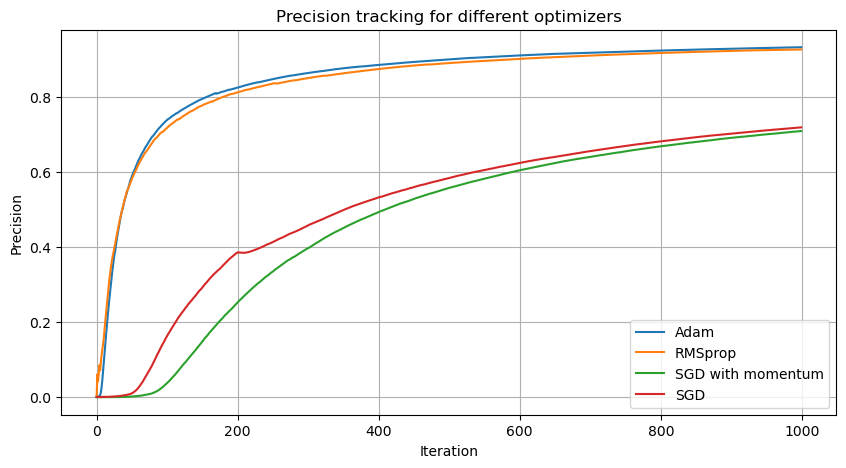

In [41]:
# Comparing the precision tracking of different optimizers
plt.figure(figsize=(10, 5))
plt.plot(precision_tracking_adam_numpy, label="Adam")
plt.plot(precision_tracking_rmsprop_numpy, label="RMSprop")
plt.plot(precision_tracking_SGDmomentum_numpy, label="SGD with momentum")
plt.plot(precision_tracking_SGD_numpy, label="SGD")
plt.xlabel("Iteration")
plt.ylabel("Precision")
plt.title("Precision tracking for different optimizers")
plt.grid()
plt.legend()
plt.show()

In the figure above, we conducted tracking the loss function over 1000 iterations for 4 optimizers. Obviously, the **ADAM optimizer** performs the best among all, whose precision given is around 0.94. The 2 SGD Optimizers did not perform so well although the condition is chosen at their best learning rate.

## 5. Conclusion

- In this project, we have discovered how to use Pytorch to build a simple neural network and train it to solve a simple image segmentation problem.
- We have also learned how to use different optimization algorithms and how to tune the hyperparameters like learning rate and to change the optimizer choice to get the best performance and results.

## 6. To do
- Understand more about the convolutional neural network and how it works. Is their any sence in each layer of the network?
- Change the architecture of the network and see how it affects the performance of the model.